# <a id='toc1_'></a>[Metacritic's games data analysis](#toc0_)

## <a id='toc1_1_'></a>[Introduction](#toc0_)

In the dynamic world of video games, understanding the landscape through data can unveil patterns, preferences, and perceptions that shape the industry. This report delves into an exploratory data analysis (EDA) of game data from Metacritic, a leading aggregator of video game reviews. By meticulously scraping data on various games, including their genres, platforms, critic scores, and user ratings, we aim to uncover insights that could guide gamers, developers, and industry stakeholders in their decisions.

This analysis not only reveals the quality and popularity of games across different genres and platforms but also highlights the evolving trends within the gaming community. Through a blend of statistical techniques and visual storytelling, this report presents a detailed exploration of the gaming landscape as reflected in Metacritic's vast database.

By bridging data science with video game analytics, we embark on a journey to decode the metrics that define game success and player satisfaction. The following sections will outline the methodology, present the findings from our EDA, and discuss the insights gleaned from this analysis. Whether you're a seasoned gamer, an aspiring developer, or simply intrigued by the analytics behind entertainment, this report offers a comprehensive overview of the current state and future directions of video games.

**Table of contents**<a id='toc0_'></a>    
- [Metacritic's games data analysis](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [Methodology](#toc1_2_)    
  - [Initial Data Cleaning and Preparation](#toc1_3_)    
      - [Dataset Structure](#toc1_3_1_1_)    
  - [Exploratory Data Analysis](#toc1_4_)    
      - [Games per Year](#toc1_4_1_1_)    
    - [Games per Month](#toc1_4_2_)    
    - [High vs Low Metascore Games per Year](#toc1_4_3_)    
    - [Distribution of Game Metascores](#toc1_4_4_)    
    - [Distribution of Games by Rating](#toc1_4_5_)    
    - [Number of games released on each platfrom](#toc1_4_6_)    
    - [Average Metascore Trend over Time](#toc1_4_7_)    
    - [Top Rated Game Metascore by Year](#toc1_4_8_)    
    - [Correlation between Metascore and Platform Scores](#toc1_4_9_)    
    - [Distribution of Number of Platforms per Game](#toc1_4_10_)    
    - [Platform Score Distribution for Multi-Platform Games](#toc1_4_11_)    
    - [Average of Average Platform Scores for Multi-Platform Games](#toc1_4_12_)    
    - [Comparison of Game Quality by Rating Category](#toc1_4_13_)    
    - [Titles and descripitions word clouds](#toc1_4_14_)    
  - [Insights and Interpretations](#toc1_5_)    
  - [Conclusion](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Methodology](#toc0_)

This project embarked on its journey with the critical task of data collection, a foundational step necessitated by the absence of an open API from Metacritic. Given this constraint, I resorted to the development of a custom scraper designed to ethically gather available data from the site, in strict adherence to the directives outlined in Metacritic's 'robots.txt' file. This ensures our data collection process respects the website's guidelines, prioritizing ethical scraping practices.

The intricacies of the scraping tool and the methodology employed in data collection are detailed in a separate notebook, dedicated to the scraper's code and its operational framework. The focus of this report, however, is squarely on the analytical insights derived from the scraped data, illuminating trends, patterns, and anomalies within the gaming landscape as presented on Metacritic.

For the analysis, Python was the language of choice, favored for its robust ecosystem and the powerful libraries it supports. The following libraries were instrumental in our exploration:

* Pandas: Employed for its extensive data manipulation capabilities, allowing for efficient data cleaning, transformation, and aggregation.
* NumPy: Utilized for its comprehensive support for numerical computations, enhancing the handling of arrays and matrices which are crucial for data analysis.
* Matplotlib: Chosen for its versatility in creating static, interactive, and animated visualizations, enabling the presentation of data in a visually engaging manner.
* Ast: Used for parsing Python literals from strings, aiding in the processing of data stored in text formats.
* WordCloud: Incorporated to generate visually striking representations of word frequency distributions, offering a unique perspective on textual data, such as game titles or descriptions.

This methodology section underscores the thoughtful selection of tools and approaches tailored to navigate the challenges of data collection and to illuminate the insights hidden within the vast dataset acquired from Metacritic. Through this analytical voyage, we aim to unravel the nuances of the gaming industry, guided by data-driven exploration and visual storytelling.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from wordcloud import WordCloud

## <a id='toc1_3_'></a>[Initial Data Cleaning and Preparation](#toc0_)

Before diving into the exploratory data analysis, it is essential to understand the structure of the dataset collected from Metacritic and prepare it for analysis. The dataset comprises several key fields, each offering unique insights into the video games listed on Metacritic. Below is a brief overview of the dataset's structure, followed by the steps undertaken for data cleaning and preparation.

#### <a id='toc1_3_1_1_'></a>[Dataset Structure](#toc0_)
The dataset contains the following columns:

* Title: The name of the video game.
* Release Date: The date when the game was released, formatted as YYYY-MM-DD.
* Rating: The ESRB rating of the game, indicating its suitability for different age groups (e.g., E for Everyone, T for Teen, M for Mature).
* Description: A brief description or summary of the game, providing context about its theme, storyline, or gameplay mechanics.
* Metascore: The aggregated score assigned by Metacritic, based on reviews from professional critics, scaled from 0 to 100.
* Platforms: A list of platforms on which the game is available. This is stored as a list of strings, with each platform represented by its common abbreviation or name.
* Platform Scores: Corresponding scores for the game on each platform listed, stored as a list of strings. These scores reflect the Metascore for the game on each respective platform.

In [2]:
games = pd.read_csv("metacritic_games_data.csv") # load the data
games.head() # display top 5 rows

,title,release_date,rating,description,metascore,platforms,platform_scores
0,The Legend of Zelda: Ocarina of Time,1998-11-23,E,"As a young boy, Link is tricked by Ganondorf, ...",99,['nintendo-64'],['99']
1,SoulCalibur,1999-09-08,T,"This is a tale of souls and swords, transcendi...",98,"['mobile', 'dreamcast', 'xbox-360']","['73', '98', '79']"
2,Grand Theft Auto IV,2008-04-29,M,[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,"['pc', 'ps3', 'xbox-360']","['90', '98', '98']"
3,Super Mario Galaxy,2007-11-12,E,[Metacritic's 2007 Wii Game of the Year] The u...,97,['wii'],['97']
4,Super Mario Galaxy 2,2010-05-23,E,"Super Mario Galaxy 2, the sequel to the galaxy...",97,['wii'],['97']


In [3]:
# Convert the 'release_date' column to datetime format for easier manipulation and analysis
games['release_date'] = pd.to_datetime(games['release_date'])

# Replace placeholder string 'Metascore not available' with -1 for numeric consistency
# and convert the 'metascore' column to integers to allow mathematical operations
games['metascore'] = games['metascore'].replace('Metascore not available', -1).astype(int)

# Ensure 'metascore' column is in integer format in case it wasn't converted properly earlier
games['metascore'] = games['metascore'].astype(int)

# Explicitly cast the 'description' column to string to avoid any type-related errors during text processing
games['description'] = games['description'].astype(str)

# Replace any 'K' ratings with 'E' to maintain consistency in ESRB ratings
# as 'K' is an outdated rating that has been replaced by 'E' for 'Everyone'
games['rating'] = games['rating'].str.replace('K', 'E')


In [4]:
# Create a new dataframe 'games_by_year' as a copy of 'games' to perform operations specific to yearly analysis
games_by_year = games

# Extract the year from the 'release_date' column and create a new column 'year' to facilitate analysis by year
games_by_year["year"] = games_by_year["release_date"].dt.year

# Extract the month from the 'release_date' column and create a new column 'month' to enable analysis by month
games_by_year["month"] = games_by_year["release_date"].dt.month

# Extract the day from the 'release_date' column and create a new column 'day' to allow analysis by day
games_by_year["day"] = games_by_year["release_date"].dt.day

# Display the first few rows of the dataframe to verify the correct execution of the above operations
games_by_year.head()


,title,release_date,rating,description,metascore,platforms,platform_scores,year,month,day
0,The Legend of Zelda: Ocarina of Time,1998-11-23,E,"As a young boy, Link is tricked by Ganondorf, ...",99,['nintendo-64'],['99'],1998,11,23
1,SoulCalibur,1999-09-08,T,"This is a tale of souls and swords, transcendi...",98,"['mobile', 'dreamcast', 'xbox-360']","['73', '98', '79']",1999,9,8
2,Grand Theft Auto IV,2008-04-29,M,[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,"['pc', 'ps3', 'xbox-360']","['90', '98', '98']",2008,4,29
3,Super Mario Galaxy,2007-11-12,E,[Metacritic's 2007 Wii Game of the Year] The u...,97,['wii'],['97'],2007,11,12
4,Super Mario Galaxy 2,2010-05-23,E,"Super Mario Galaxy 2, the sequel to the galaxy...",97,['wii'],['97'],2010,5,23


## <a id='toc1_4_'></a>[Exploratory Data Analysis](#toc0_)

#### <a id='toc1_4_1_1_'></a>[Games per Year](#toc0_)

My analysis of game releases per year reveals significant industry trends. The rapid increase in releases from the late 1990s into the 2000s likely reflects the industry's expansion and the growing mainstream popularity of video games. The peak period in the mid-2000s may correspond with the advent of new gaming platforms and the rise of indie game development facilitated by digital distribution.

The plateau phase suggests market stabilization, where the number of new titles released each year remained relatively constant. This could indicate a saturated market where publishers and developers aimed to maintain a steady stream of content while balancing competition and market demand.

The decline in the number of game releases in recent years might be indicative of several factors: a shift in industry focus towards quality over quantity, the rising costs of game development, and perhaps market consolidation with fewer, larger titles dominating the landscape. The influence of new distribution models, such as subscription services, and the impact of global events on production schedules could also play a role in the reduced frequency of game releases.

It is important to note that while the chart shows a decline in the number of games, it does not account for the scale or success of the games released. Further analysis could determine whether the decrease in quantity correlates with an increase in average production values or a focus on longer, more involved games that offer ongoing content updates over time.

These trends provide valuable insights into the evolution of the gaming industry and point towards a future where the business models and production strategies might continue to evolve, potentially affecting release patterns further.

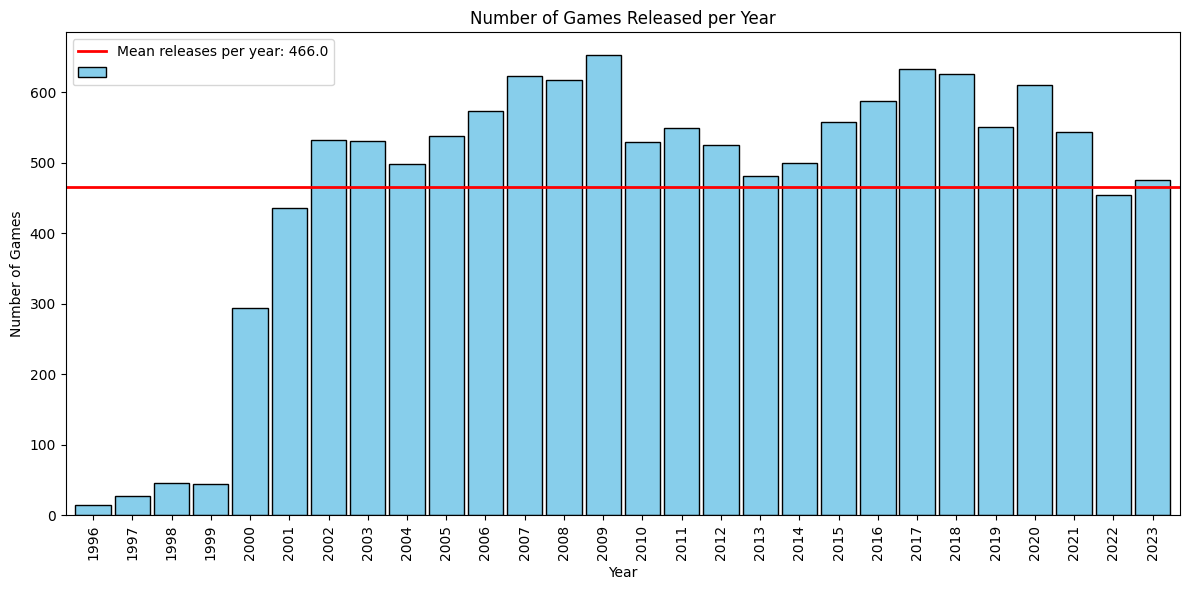

In [32]:
# Exclude the incomplete data for the year 2024 and the starting year 1995 from the dataset to avoid skewing the analysis.
games_per_year_filtered = games_by_year[
    (games_by_year["year"] != 2024) & (games_by_year["year"] != 1995)
]

# Group the filtered data by 'year' and count the number of titles to determine the annual game release volume.
games_per_year = games_per_year_filtered.groupby("year")["title"].count()

# Compute the average number of games released per year, rounding to the nearest whole number for simplicity.
mean_games_per_year = games_per_year.mean().round()

# Begin plotting the number of games released per year as a bar chart.
plt.figure(figsize=(12, 6))  # Set the figure size for better visibility of the data.

# Create a bar plot with a consistent width and defined colors for better visual distinction.
games_per_year.plot(kind="bar", width=0.9, color="skyblue", edgecolor="black")

# Draw a horizontal line representing the average number of game releases per year on the plot.
plt.axhline(
    mean_games_per_year, color="red", linewidth=2
)  # Add a mean line for reference.

# Title and label the plot to provide context to the chart.
plt.title("Number of Games Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Games")

# Add a legend to the plot, which includes the mean number of releases per year for additional insight.
plt.legend(labels=[f"Mean releases per year: {mean_games_per_year}", ""])

# Set the x-axis ticks to display each year and rotate them for better legibility.
plt.xticks(
    rotation=90
)  # Rotate the x-axis labels to vertical to ensure they are readable.

# Adjust the layout to make sure labels and titles are not cut off.
plt.tight_layout()

# Render the plot to the screen.
plt.show()


### <a id='toc1_4_2_'></a>[Games per Month](#toc0_)

The bar chart below illustrates the distribution of game releases by month. It is evident that there are specific months where the gaming industry sees a higher number of game releases. Notably, the last quarter of the year, particularly October and November, shows a significant increase in the number of games coming to market. This trend likely aligns with the holiday season, where consumer spending is traditionally higher, and publishers aim to capitalize on the festive shopping surge.

Conversely, the beginning of the year, specifically January, experiences the lowest number of game releases, which may be attributed to the post-holiday slump in consumer spending. The industry seems to follow a cyclical pattern, with releases ramping up towards the year's end and tapering off at the beginning of the next year.

These insights suggest strategic planning by game publishers to align major releases with key retail periods, potentially to maximize visibility and sales. The data underscores the importance of seasonality in the gaming industry's marketing and release strategies.

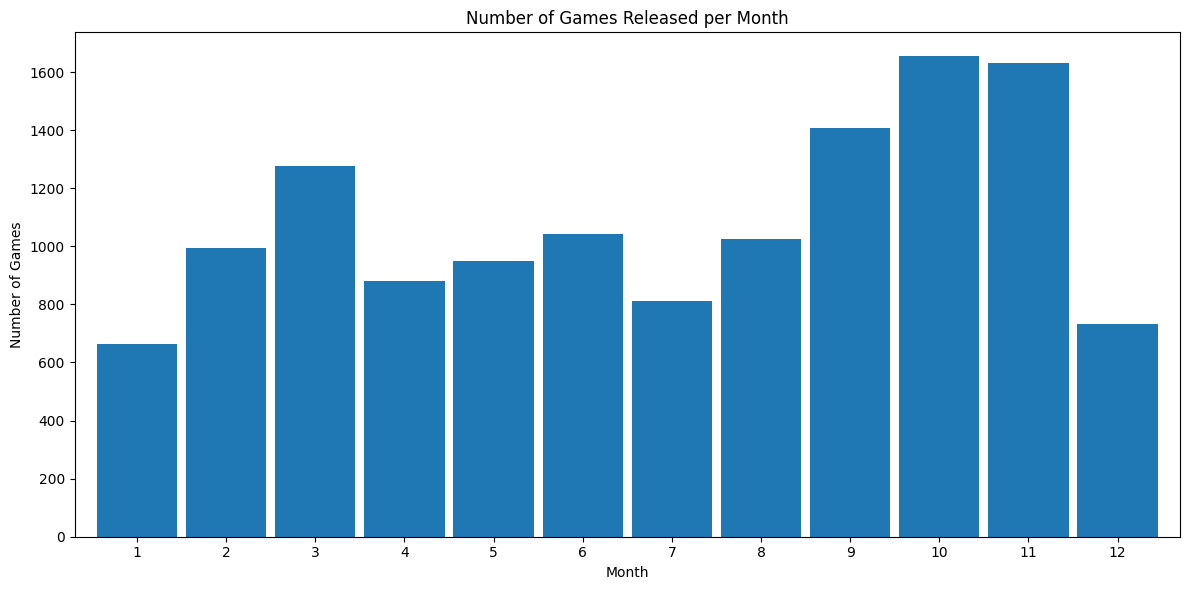

In [35]:
# Aggregate the data to count the number of games released in each month across all years
games_per_month = games_by_year.groupby("month")["title"].count()

# Initiate a plot with a specified figure size for clarity
plt.figure(figsize=(12, 6))

# Plot the aggregated data as a bar chart with a uniform bar width
# Bar charts are chosen for their clear representation of categorical data
games_per_month.plot(kind="bar", width=0.9)

# Add a title and axis labels to the plot for context
plt.title("Number of Games Released per Month")
plt.xlabel("Month")
plt.ylabel("Number of Games")

# Set the x-axis ticks to display each month and disable rotation for better legibility
# since month labels (1-12) are generally short and do not require rotation
plt.xticks(rotation=0)

# Utilize the tight layout to optimize spacing of plot elements ensuring clear presentation
plt.tight_layout()

# Display the resulting bar chart showing the monthly distribution of game releases
plt.show()


### <a id='toc1_4_3_'></a>[High vs Low Metascore Games per Year](#toc0_)

The bar chart below compares the yearly release counts of high Metascore games (scores of 85 or above) versus low Metascore games (scores below 50). The data shows a variable distribution with certain years having a higher release of high Metascore games and others dominated by low Metascore games. The most recent years show a noticeable increase in the release of high Metascore games.

Upon reviewing the distribution of high versus low Metascore game releases over the years, a few key observations stand out. Initially, low Metascore games greatly outnumbered high Metascore games. This disparity has fluctuated over time, with some years showing a closer parity between the two categories. Notably, in the most recent years, there has been a surge in the release of high Metascore games, suggesting a possible shift in the industry towards quality and critical acclaim. This could be indicative of a maturing industry where developers and publishers are placing a greater emphasis on delivering high-quality titles that are well-received by critics. It might also reflect evolving consumer expectations, with a market that increasingly rewards excellence over mediocrity. The data points to a dynamic industry landscape where the balance between quantity and quality is in constant flux.

Disclamer: The cutoff points (>85, <50) where chosen subjectievly by personal experience.

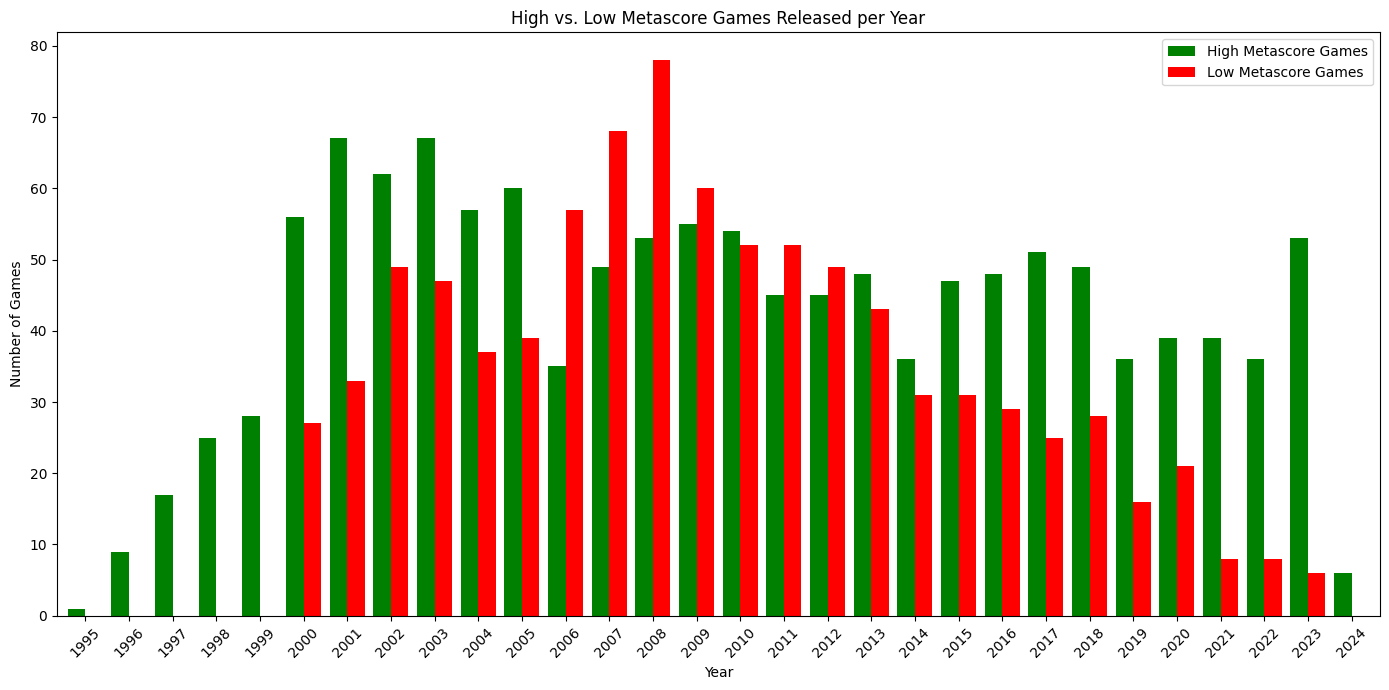

In [38]:
# Segment the games into two categories based on their Metascore: high (85 and above) and low (below 50).
high_metascore_games = games_by_year[games_by_year["metascore"] >= 85]
low_metascore_games = games_by_year[games_by_year["metascore"] < 50]

# For each group, count the number of games released annually to understand yearly trends.
high_metascore_count = high_metascore_games.groupby("year").size()
low_metascore_count = low_metascore_games.groupby("year").size()

# Create a new DataFrame to store and easily compare the counts of high and low Metascore games per year.
counts_df = pd.DataFrame(
    {
        "High Metascore Games": high_metascore_count,
        "Low Metascore Games": low_metascore_count,
    }
)

# Impute missing values (years with no game releases in a category) with zero for an accurate year-on-year comparison.
counts_df = counts_df.fillna(0)

# Begin creating a bar plot to visually compare the number of high vs. low Metascore games released each year.
# Convert the index to string to prevent any potential formatting issues with the x-axis labels.
counts_df.index = counts_df.index.map(str)

# Plot a bar chart with specified colors for each Metascore category for visual distinction.
counts_df.plot(kind="bar", figsize=(14, 7), width=0.8, color=["green", "red"])

# Title and label the plot to enhance understanding of the data being presented.
plt.title("High vs. Low Metascore Games Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Games")

# Rotate x-axis labels to avoid overlapping text and improve readability.
plt.xticks(rotation=45)

# Use 'tight_layout' to automatically adjust subplot params for the figure to fit into the box.
plt.tight_layout()

# Include a legend to clarify the meaning of the bar colors.
plt.legend()

# Display the plot showing the comparison between high and low Metascore game releases over the years.
plt.show()

### <a id='toc1_4_4_'></a>[Distribution of Game Metascores](#toc0_)

The histogram below depicts the distribution of game Metascores, providing a visual representation of how many games fall within various scoring brackets. The most densely populated range lies between scores of 60 to 80, which suggests that the majority of games receive scores within this middle range. There are significantly fewer games with very low scores (below 20) and very high scores (above 90), indicating these are less common outcomes in game reviews.

The distribution of game Metascores forms a bell-shaped curve, centered around the 60 to 80 score range. This central concentration implies that most games are perceived as moderately well-made, aligning with an average or above-average quality standard. Very high and very low scores are outliers, reflecting exceptional quality or significant shortcomings, respectively. These findings might suggest that while there is a wide range of game quality, most titles tend to cluster around a common level of acceptability, which could be tied to industry standards or consumer expectations.

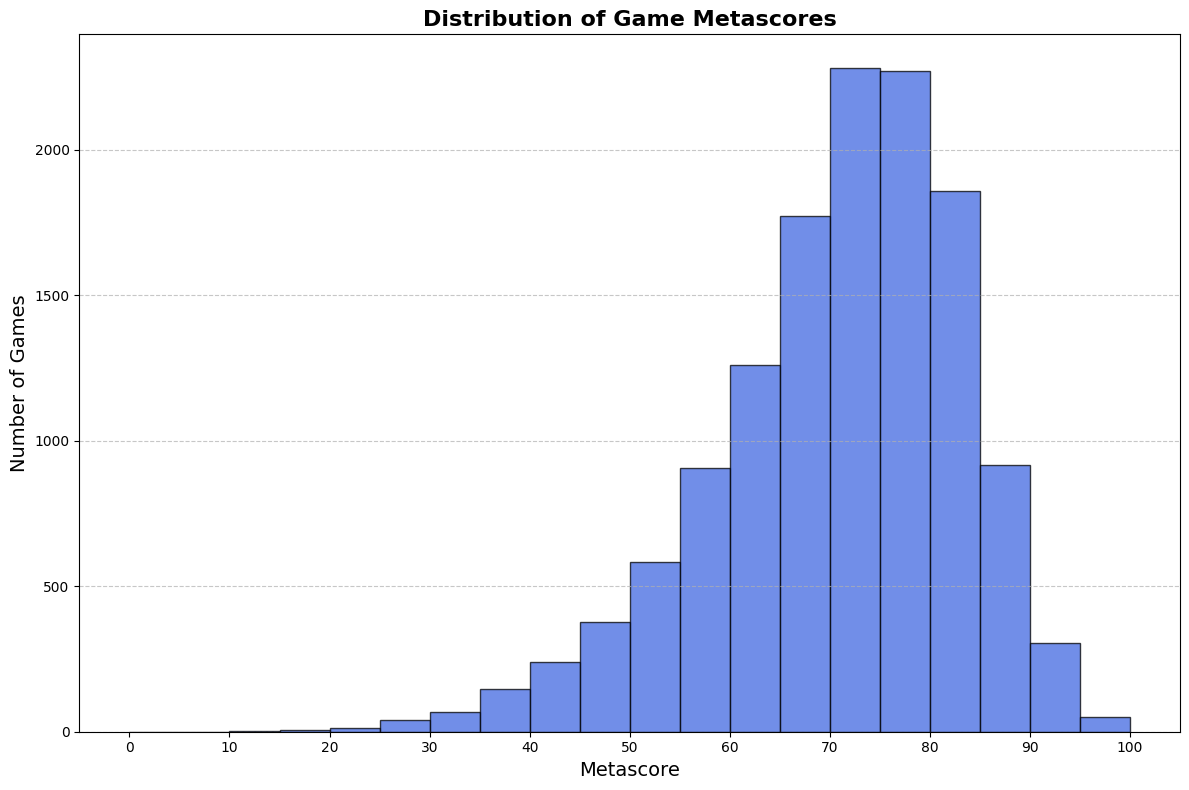

In [8]:
# Determine the range of metascores to set appropriate bins
min_metascore = games_by_year['metascore'].min() + 1 # Avoiding "Metascore not available" that is under -1
max_metascore = games_by_year['metascore'].max()

# Calculate the number of bins to use - aiming for a bin width of around 5 score units for clarity
bins = np.arange(start=min_metascore, stop=max_metascore + 5, step=5)

plt.figure(figsize=(12, 8))  # Adjusting figure size for better visualization

# Plotting the histogram with the new bins
plt.hist(games_by_year['metascore'], bins=bins, edgecolor='k', alpha=0.75, color='royalblue')

plt.title('Distribution of Game Metascores', fontsize=16, fontweight='bold')
plt.xlabel('Metascore', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)

# Removing x-ticks rotation and setting a smaller step for readability
plt.xticks(np.arange(min_metascore, max_metascore + 10, 10))

# Adding grid lines for better readability of values
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust the layout
plt.show()


### <a id='toc1_4_5_'></a>[Distribution of Games by Rating](#toc0_)

The pie chart below portrays the distribution of video games by their ESRB rating categories. The largest segments belong to 'T' (Teen) and 'E' (Everyone), constituting 29.6% and 26.7% of the games respectively, which indicates that the majority of games are targeted towards a general audience including younger players. Games rated 'M' (Mature) make up a significant portion as well, at 16.1%, reflecting a substantial market for adult-oriented titles. The 'E10' (Everyone 10 and older) category follows closely, representing 12.5% of games. Notably, very few games are rated 'AO' (Adults Only) or 'RP' (Rating Pending), which are at 0% and 0.1% respectively, indicating their rarity. A segment of the games, 14.9%, could not be categorized due to a lack of rating information.

The data suggests a gaming industry that caters predominantly to a younger demographic, with the 'T' and 'E' ratings combined representing over half of all games. However, there is also a notable presence of 'M' rated games, highlighting a diverse market that also accommodates mature content. The extremely low prevalence of 'AO' rated games may reflect the industry's tendency to avoid producing content with such a restrictive rating due to limited marketability. The 'Rating not found' segment suggests that for a significant number of games, ratings may not be available or applied, possibly due to them being in pre-release stages, or they could be indie or international games not widely rated by the ESRB. This distribution provides an overview of the content rating landscape in the gaming industry and may inform developers, marketers, and retailers about the potential market segments to target.

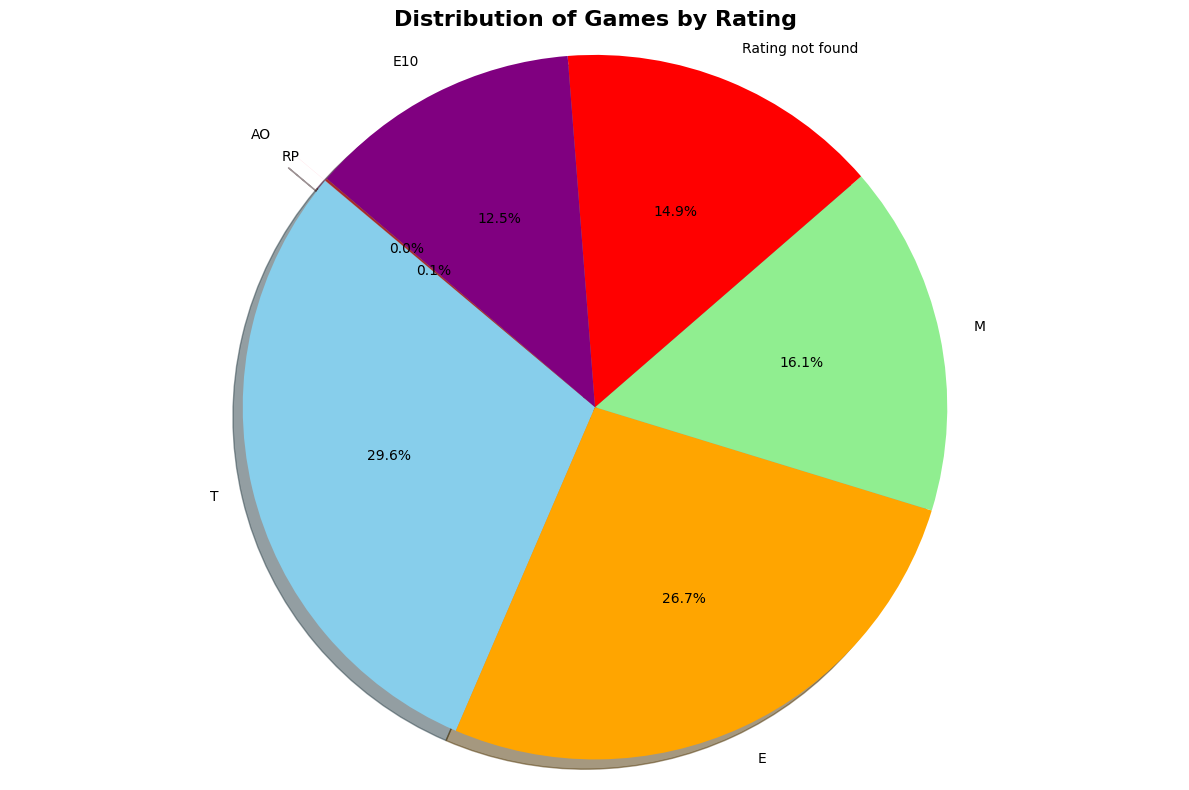

In [9]:
# Count the number of games by rating
rating_counts = games_by_year['rating'].value_counts()

# Define colors for each rating to make the chart more visually distinct
colors = ['skyblue', 'orange', 'lightgreen', 'red', 'purple', 'brown', 'pink', 'grey', 'yellow', 'black']
# Ensure there are enough colors for each rating
colors = colors[:len(rating_counts)]

# Explode the smallest segment slightly
explode = [0.1 if i == rating_counts.idxmin() else 0 for i in rating_counts.index]

# Increase figure size
plt.figure(figsize=(12, 8))

# Plot pie chart with adjusted autopct fontsize and explode for smallest segment
plt.pie(rating_counts, labels=rating_counts.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, colors=colors, explode=explode, shadow=True)

plt.title('Distribution of Games by Rating', fontsize=16, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

### <a id='toc1_4_6_'></a>[Number of games released on each platfrom](#toc0_)

The bar below chart demonstrates the number of games released across various gaming platforms. The PC platform leads by a significant margin, followed by the PS4 and Nintendo Switch. This prominence indicates the PC's sustained popularity and wide adoption by game developers as a primary gaming and development platform. Consoles like the PS4 and Nintendo Switch also show strong libraries, reflecting their popularity and market penetration.

The data reveals the PC as the most prolific platform for game releases, which may be due to the platform's open nature and accessibility for developers. The PS4 and Nintendo Switch follow, showcasing their success and appeal to game developers and players alike. There is a notable drop-off after the leading platforms, with legacy consoles and handhelds showing smaller libraries, which aligns with their respective market life cycles. The distribution across platforms underscores the evolving landscape of gaming, with a clear dominance of certain platforms that have become preferred choices for game releases.

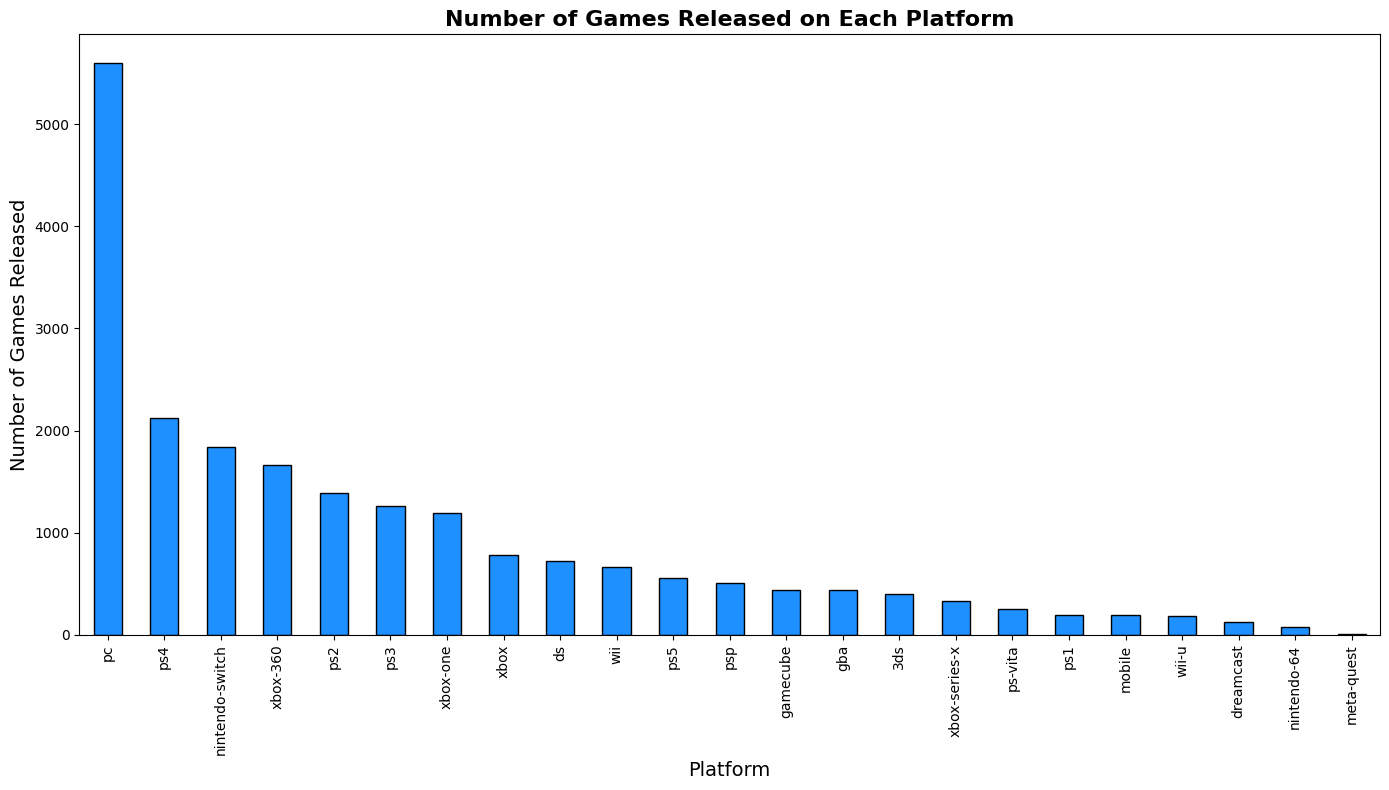

In [10]:
# Convert the string representations of lists in 'platforms' and 'platform_scores' columns to actual list objects
# This enables easier manipulation of these columns as lists rather than as strings
games_by_year['platforms'] = games_by_year['platforms'].apply(ast.literal_eval)
games_by_year['platform_scores'] = games_by_year['platform_scores'].apply(ast.literal_eval)

# Iterate over each game entry to pair its platforms with their corresponding scores
# and collect these pairs in a list to facilitate the creation of a new dataframe
rows = []
for i, row in games_by_year.iterrows():
    for platform, score in zip(row['platforms'], row['platform_scores']):
        rows.append({'title': row['title'], 'platform': platform, 'score': score})

# Construct a new DataFrame from the list of platform-score pairs,
# where each game, platform, and score has its own row for a normalized structure
paired_df = pd.DataFrame(rows)

# Pivot the newly created dataframe to create a wider format where each platform is a column,
# and each game's score on that platform is listed as a row
platform_scores_pivot = paired_df.pivot_table(index='title', columns='platform', values='score', aggfunc='first')

# Count the number of game releases per platform by summing the non-null entries in each platform's column
# This count represents the number of times a game was released on that platform
platform_counts = platform_scores_pivot.count().sort_values(ascending=False)

# Begin plotting the number of games released per platform as a bar chart
plt.figure(figsize=(14, 8))  # Define a large figure size to accommodate the numerous platforms

# Create a bar chart to visually compare the count of game releases across platforms
platform_counts.plot(kind='bar', color='dodgerblue', edgecolor='black')

# Add a title and axis labels to the chart for context and clarity
plt.title('Number of Games Released on Each Platform', fontsize=16, fontweight='bold')
plt.xlabel('Platform', fontsize=14)
plt.ylabel('Number of Games Released', fontsize=14)

# Rotate the platform names on the x-axis to ensure that each label is legible
plt.xticks(rotation=90)

# Apply tight_layout to adjust the spacing and layout of the plot elements,
# ensuring that everything fits within the figure area without overlap
plt.tight_layout()

# Display the final bar chart showing the distribution of game releases across different platforms
plt.show()


### <a id='toc1_4_7_'></a>[Average Metascore Trend over Time](#toc0_)

The line chart below displays the trend in the average Metascore for video games from 1995 to 2024. After a peak in the mid-1990s, there is a sharp decline towards the early 2000s, followed by a period of stabilization. From 2010 onwards, there is a gradual but consistent upward trend, suggesting a general increase in game quality or perhaps a change in the reviewing standards or practices.

Over nearly three decades, the average Metascore of video games has experienced notable fluctuations. The initial peak could be attributed to a smaller volume of games being produced, possibly with higher individual quality. The subsequent decline and plateau may reflect the industry's rapid expansion, increased competition, and perhaps a larger influx of games with diverse quality levels. The gradual increase in scores from 2010 suggests that game developers may be focusing more on quality, or it might indicate a shift in the critical reception of games. This upward trend could also suggest that as the industry has matured, so have the standards and expectations of game quality. This analysis provides insight into the general quality trends of the gaming industry over time, with a positive outlook in recent years.

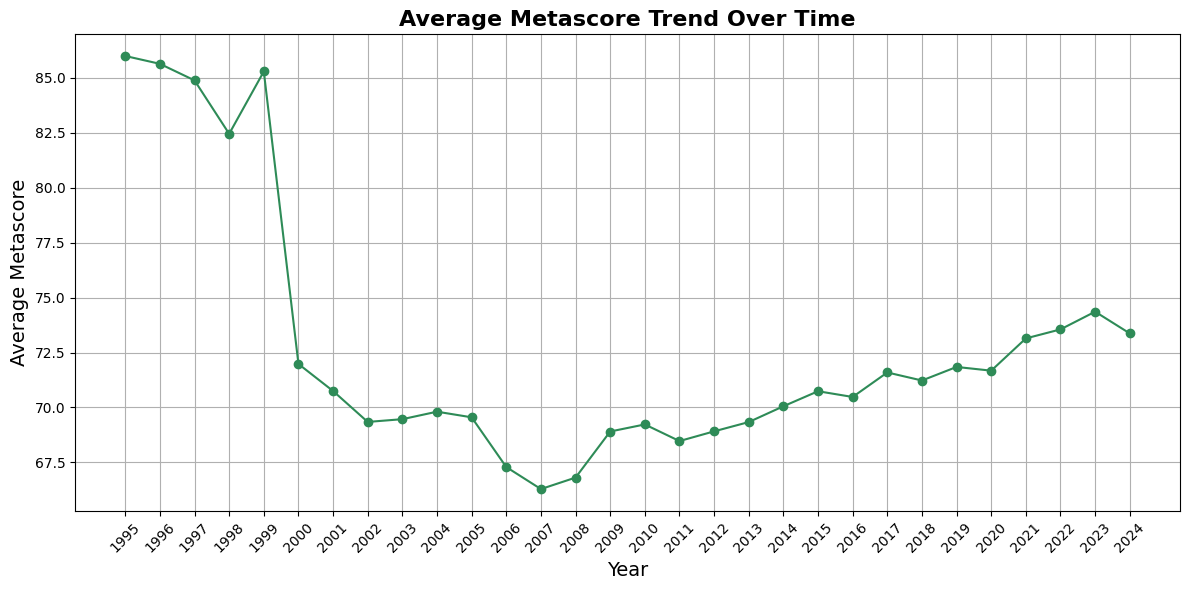

In [11]:
# Calculate the average Metascore for each year to assess the annual trend in game quality.
average_metascore_per_year = games_by_year.groupby('year')['metascore'].mean()

# Begin creating a line plot to visualize how the average Metascore has evolved over time.
plt.figure(figsize=(12, 6))  # Set the size of the plot for clear visibility of data points and trends.

# Plot the average Metascore per year as a line graph with markers at each data point for emphasis.
average_metascore_per_year.plot(kind='line', color='seagreen', marker='o')

# Add a title and labels to the axes to provide context to the plot.
plt.title('Average Metascore Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Metascore', fontsize=14)

# Enable the grid for better readability of the plot, making it easier to track data points against the axes.
plt.grid(True)

# Set the x-axis ticks to show every year in the dataset and rotate them to prevent overlapping of labels.
plt.xticks(range(min(games_by_year['year']), max(games_by_year['year'])+1, 1), rotation=45)

# Apply tight layout to ensure that all plot elements are neatly arranged and no labels are cut off.
plt.tight_layout()

# Display the plot which illustrates the trend of average Metascores over the years.
plt.show()


### <a id='toc1_4_8_'></a>[Top Rated Game Metascore by Year](#toc0_)

The bar chart below represents the Metascores of the highest-rated games for each year from 1995 to 2024. The scores generally hover above the high 80s and into the 90s, showcasing a consistently high quality among the top-rated games across the years. The chart also highlights the variety of games that have achieved the status of being the top-rated in their release year, indicating a diversity in genres and gameplay experiences that have been well-received by critics.

Conclusion
The enduring high quality of top-rated games year-on-year illustrates the gaming industry's ability to continually produce standout titles that resonate well with critics. The consistent achievement of high Metascores among these games suggests that the best of the gaming industry is characterized by excellence in design, storytelling, and innovation. Additionally, the variation in titles points to a dynamic market where different franchises and developers have peaked at different times, indicating healthy competition and creative vibrancy within the industry. This trend of high-quality game production is promising for the future of gaming, with each year bringing a new title that sets the benchmark for excellence.

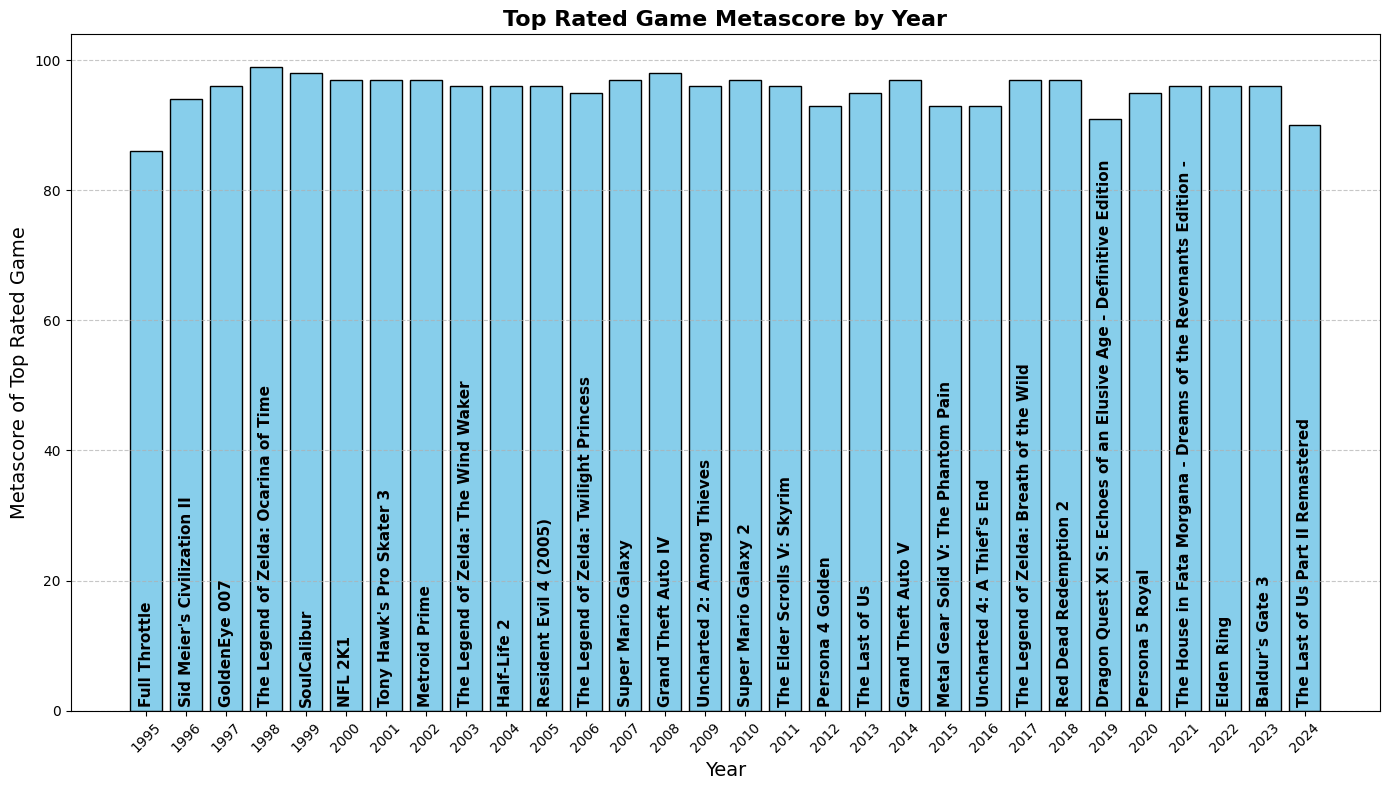

In [12]:
# Identify the game with the highest Metascore for each year by grouping the dataset by year
# and finding the index of the game with the maximum Metascore in each group.
top_rated_idx = games_by_year.groupby('year')['metascore'].idxmax()

# Use the indices found to select the corresponding games from the original dataset.
# This creates a subset containing only the top-rated game of each year.
top_rated_games_each_year = games_by_year.loc[top_rated_idx]

# Initiate plotting of the top-rated games' Metascores over the years.
plt.figure(figsize=(14, 8))  # Specify a larger figure size to accommodate the details and annotations.

# Create a bar chart where each bar represents the Metascore of the top-rated game for a given year.
bars = plt.bar(top_rated_games_each_year['year'], top_rated_games_each_year['metascore'], color='skyblue', edgecolor='black')

# Set the title and labels for the chart, with increased font sizes for emphasis and readability.
plt.title('Top Rated Game Metascore by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Metascore of Top Rated Game', fontsize=14)

# Loop through each bar to annotate it with the title of the corresponding top-rated game.
# The annotations are positioned based on the bar's height and centered horizontally.
for bar, game_title in zip(bars, top_rated_games_each_year['title']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 0.5, game_title, ha='center', va='bottom', rotation=90, fontsize=11, color='black', weight='bold')

# Set the x-axis ticks to display the years and rotate them for better legibility.
plt.xticks(top_rated_games_each_year['year'], rotation=45)

# Add a grid on the y-axis to enhance readability of the Metascores.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout of the plot elements to ensure everything is displayed neatly.
plt.tight_layout()

# Render the chart to visualize the Metascore trend of top-rated games over the years.
plt.show()


### <a id='toc1_4_9_'></a>[Correlation between Metascore and Platform Scores](#toc0_)
The scatter plot shows a comparison between individual platform scores and the Metascore for games, with a very high correlation coefficient of 0.94. This suggests a strong positive relationship between the two variables, indicating that games which score well on one platform tend to score similarly across other platforms.

The analysis indicates a strong consistency in game quality across different platforms, as reflected by the high correlation between platform-specific scores and overall Metascores. This could imply that a game's core experience and quality are maintained regardless of the platform it is played on. The high correlation also suggests that reviews are consistent in their evaluation criteria across different platforms, leading to similar scores. Game developers seem to be successful in ensuring that a game's translation across platforms does not significantly impact its reception by critics.

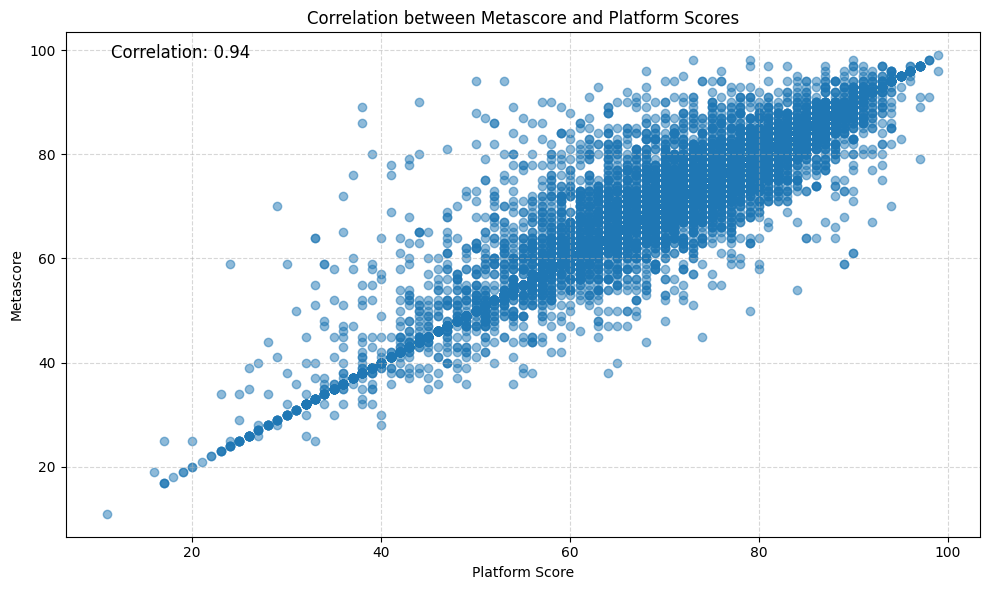

In [13]:
# Define a function to pair each game's platforms with their respective scores.
# This is necessary for a detailed analysis of scores across different platforms.
def pair_platform_scores(row):
    return list(zip(row['platforms'], row['platform_scores']))

# Apply the function to each row in the dataframe to create a list of (platform, score) pairs.
# This operation transforms the 'platforms' and 'platform_scores' columns into a paired list format for each game.
games_by_year['platform_score_pairs'] = games_by_year.apply(pair_platform_scores, axis=1)

# 'Explode' the paired lists into separate rows to facilitate analysis on a platform-by-platform basis.
# Each game will now have multiple rows if it was released on multiple platforms, one for each platform.
games_exploded = games_by_year.explode('platform_score_pairs')

# Split the (platform, score) pairs into two separate columns for clearer analysis.
# This step converts the list of tuples into a dataframe structure where each tuple element occupies its column.
games_exploded[['platform', 'platform_score']] = pd.DataFrame(games_exploded['platform_score_pairs'].tolist(), index=games_exploded.index)

# Filter out any rows where 'platform_score' is not a numeric value or where 'metascore' is missing,
# ensuring that only rows with valid scores are included in the analysis.
games_exploded = games_exploded[pd.to_numeric(games_exploded['platform_score'], errors='coerce').notnull()]
games_exploded = games_exploded[games_exploded['metascore'] > 0]

# Convert 'platform_score' to a numeric type to enable quantitative analysis.
games_exploded['platform_score'] = pd.to_numeric(games_exploded['platform_score'])

# Plot a scatter diagram to visualize the relationship between 'platform_score' and 'metascore'.
# This helps in identifying any correlation between the scores across different platforms.
plt.figure(figsize=(10, 6))
plt.scatter(games_exploded['platform_score'], games_exploded['metascore'], alpha=0.5)

# Title and label the plot to provide clarity on the data being represented.
plt.title('Correlation between Metascore and Platform Scores')
plt.xlabel('Platform Score')
plt.ylabel('Metascore')

# Calculate and display the correlation coefficient on the plot,
# providing a quantitative measure of the relationship between 'platform_score' and 'metascore'.
corr_coef = np.corrcoef(games_exploded['platform_score'], games_exploded['metascore'])[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr_coef:.2f}', transform=plt.gca().transAxes, fontsize=12)

# Add a grid to the plot to improve readability, making it easier to assess the data points' distribution.
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Adjust the layout to ensure that the plot components are displayed neatly and without overlap.
plt.tight_layout()

# Display the scatter plot, showcasing the potential correlation between platform-specific scores and overall Metascores.
plt.show()

### <a id='toc1_4_10_'></a>[Distribution of Number of Platforms per Game](#toc0_)

The histogram below displays the distribution of the number of platforms on which games are released. Most games are released on a single platform, with the frequency gradually decreasing as the number of platforms increases. There is a significant drop-off in the number of games released on more than four platforms.

The majority of games are tailored to one platform, which may indicate a focus on platform-specific optimization or exclusivity agreements. As the number of platforms per game increases, the frequency of such games decreases, suggesting that multi-platform releases are less common, potentially due to increased development complexity, costs, or strategic marketing decisions. The distribution underscores the importance of platform specificity in the gaming industry, with a smaller number of games taking on the challenge and opportunity of being accessible to a broader audience across multiple platforms.

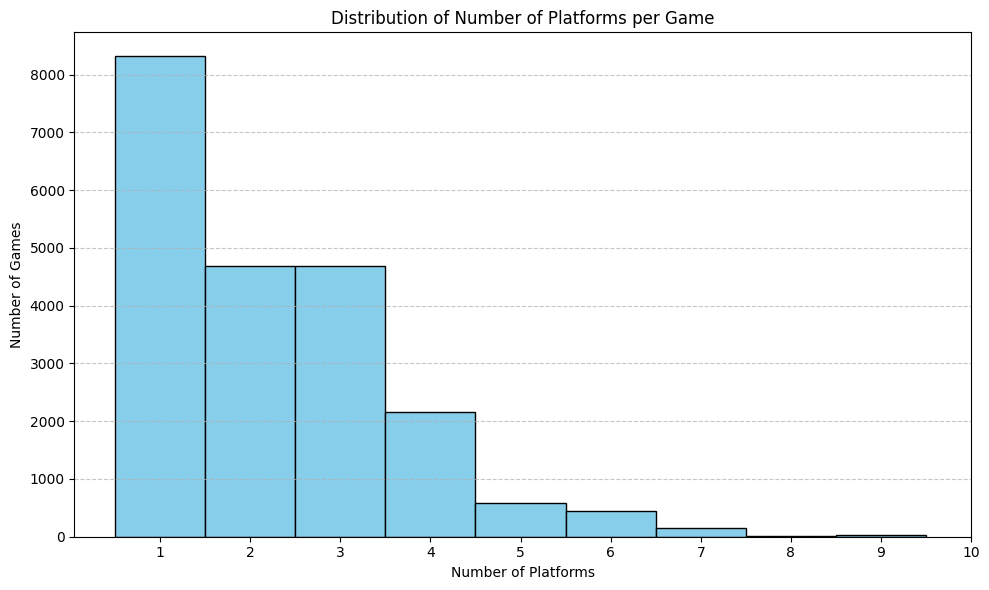

In [14]:
# Calculate how many platforms each game is available on by counting the occurrences of each game title within the platforms.
# This is done by grouping the exploded dataframe by 'title' and counting the unique 'platform' entries for each game.
games_exploded['game_platform_count'] = games_exploded.groupby('title')['platform'].transform('count')

# Filter the dataset to include only games that have been released on more than one platform.
# This helps in focusing the analysis on multi-platform games, which are of particular interest.
multi_platform_games = games_exploded[games_exploded['game_platform_count'] >= 1]

# Prepare to plot a histogram that shows the distribution of games across the number of platforms they're available on.
# This visualization aims to reveal how common multi-platform releases are within the dataset.
plt.figure(figsize=(10, 6))  # Set the figure size to ensure the histogram is clearly visible.

# Plot the histogram using the count of platforms per game.
# Bins are set to range from 1 to the maximum count of platforms a game is released on, aligning bars to the left for clarity.
plt.hist(multi_platform_games['game_platform_count'], bins=range(1, multi_platform_games['game_platform_count'].max()+1), align='left', color='skyblue', edgecolor='black')

# Add a title and axis labels to the histogram for context, making it clear what the visualization represents.
plt.title('Distribution of Number of Platforms per Game')
plt.xlabel('Number of Platforms')
plt.ylabel('Number of Games')

# Set x-ticks to reflect the range of platform counts, ensuring each possible value is represented on the x-axis.
plt.xticks(range(1, multi_platform_games['game_platform_count'].max()+1))

# Add grid lines on the y-axis to improve the readability of the histogram, making it easier to gauge the frequency of games across platform counts.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Apply a tight layout to adjust subplot parameters, ensuring the plot elements are neatly arranged without overlap.
plt.tight_layout()

# Display the histogram, offering insights into how games are distributed by the number of platforms they appear on.
plt.show()


### <a id='toc1_4_11_'></a>[Platform Score Distribution for Multi-Platform Games](#toc0_)
The box plot illustrates the distribution of scores for games released on multiple platforms, showing median scores, quartiles, and outliers for each platform. The plots reveal that while there's a range of scores across all platforms, the median scores for most platforms are above 60, indicating a generally positive reception. Some platforms show a wider spread of scores, suggesting a more significant variation in game quality or reception on those platforms. Notably, there are outliers indicating some games that scored exceptionally high or low compared to the typical range.

The distribution of scores across multiple platforms indicates that games tend to perform similarly across different systems, with a majority achieving a score of 60 or above, which denotes a generally favorable reception. The presence of outliers on every platform highlights that there can be significant deviations from the norm, with some games achieving exceptional success or underperforming relative to others. The overall similarity in score distributions suggests that multi-platform games maintain a level of quality and consistency regardless of the platform, but individual titles can still vary widely in how well they are received.

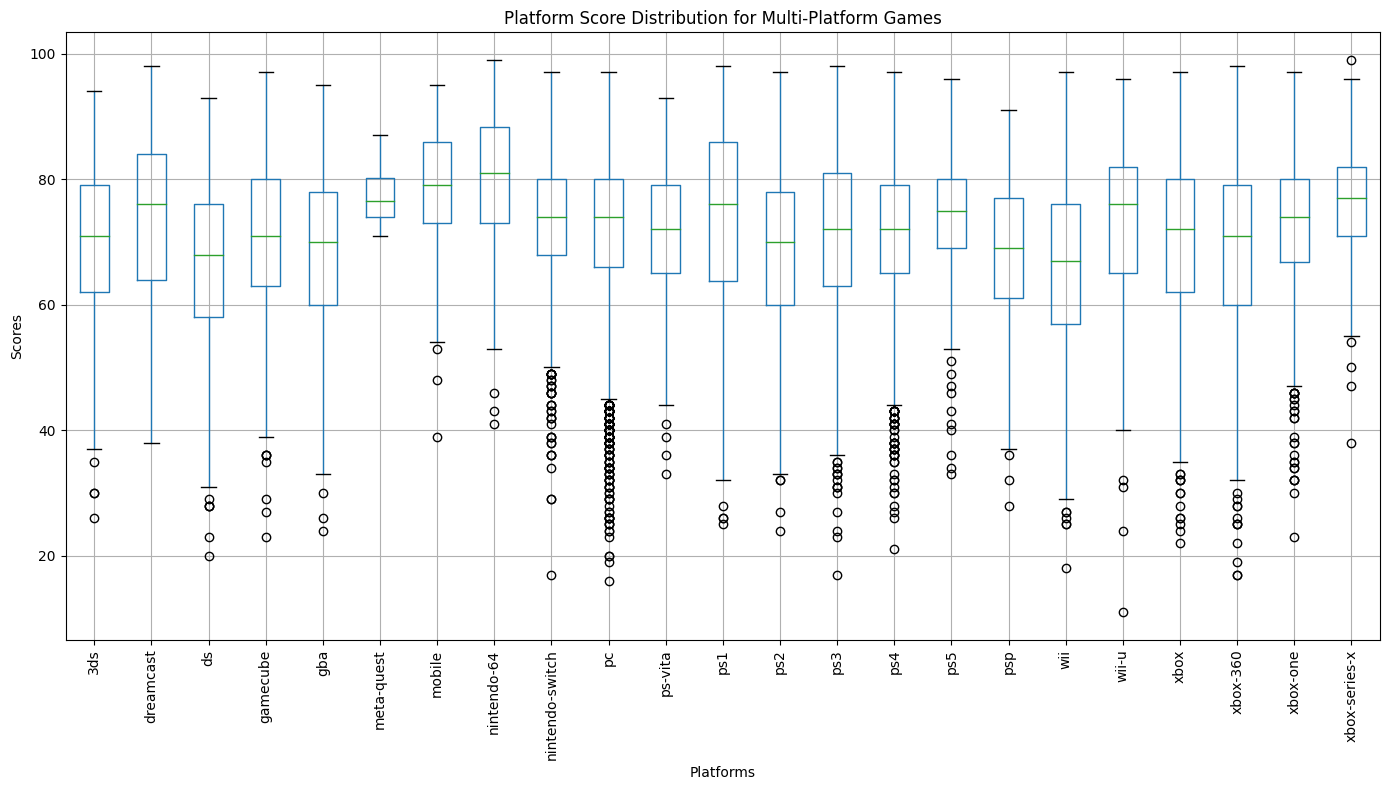

In [15]:
# Create a pivot table from the multi_platform_games DataFrame to aggregate platform scores.
# The pivot table will index by 'title', column by 'platform', and use the mean of 'platform_score' to handle any duplicate entries.
# This approach ensures that each game's score is averaged across duplicates on the same platform, providing a cleaner dataset for analysis.
pivot_scores = multi_platform_games.pivot_table(index='title', columns='platform', values='platform_score', aggfunc='mean')

# Initiate the plotting of a box plot to visually compare the distribution of platform scores across different platforms.
# The box plot is an effective way to display the central tendency, dispersion, and outliers in the dataset.
plt.figure(figsize=(14, 8))  # Set a larger figure size to accommodate the potentially large number of platforms.

# Generate the box plot from the pivot table data.
# The 'rot' parameter is set to 90 degrees to rotate the platform labels for better readability when there are many platforms.
pivot_scores.boxplot(rot=90, grid=True)

# Add a title to the plot and label the axes to provide context and improve interpretability of the visualization.
plt.title('Platform Score Distribution for Multi-Platform Games')
plt.ylabel('Scores')
plt.xlabel('Platforms')

# Apply a tight layout to ensure that all plot elements are neatly arranged, and nothing is cut off, especially important given the rotated x-axis labels.
plt.tight_layout()

# Display the box plot, which shows the distribution of scores for games across different platforms, highlighting any variations in scoring trends or outliers.
plt.show()

### <a id='toc1_4_12_'></a>[Average of Average Platform Scores for Multi-Platform Games](#toc0_)
The scatter plot below visualizes the average of average platform scores for games released on multiple platforms. The data points represent the aggregate average score for each platform, providing an overview of how games generally perform across different systems. Most platforms show average scores within the 70s, indicating a generally favorable performance. However, there is variability among platforms, with some averaging higher scores than others.

The scatter plot suggests that while multi-platform games tend to achieve favorable scores across the board, certain platforms may provide a slightly better gaming experience, as indicated by their higher average scores. This could be due to various factors, including the technical capabilities of the platforms, the demographics of their user base, or the types of games that are more commonly released on them. The plot also highlights that no single platform significantly outperforms the others on average, suggesting a level of parity in the gaming experience across the industry. This parity is beneficial for consumers, offering them a consistent quality of games regardless of their platform choice.

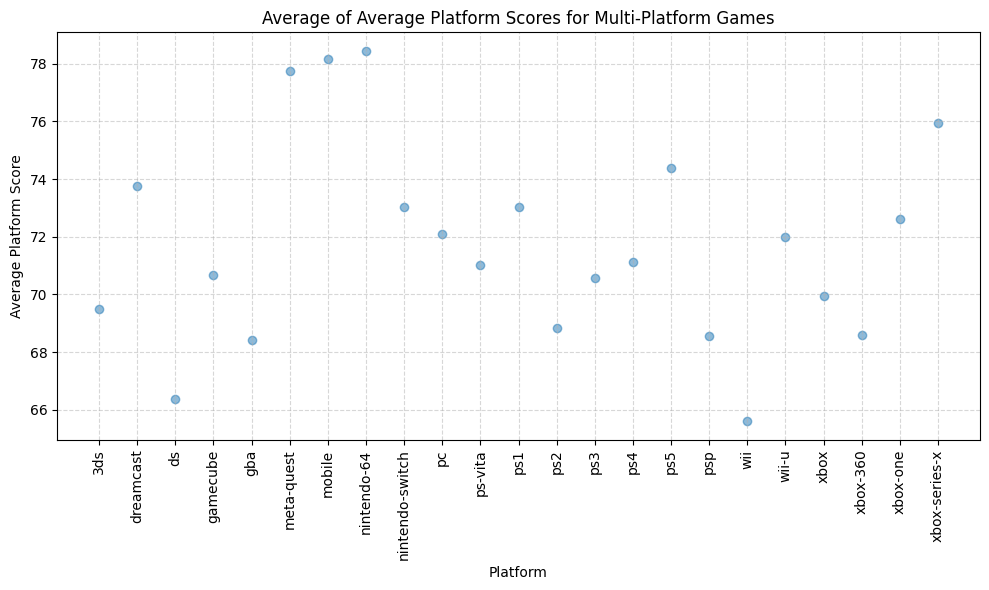

In [16]:
# First, calculate the average score for each game on each platform.
# This step involves grouping the data by both 'title' and 'platform', then calculating the mean of 'platform_score'.
# The result is a DataFrame where each row represents a game-platform combination with its average score.
platform_scores_avg = multi_platform_games.groupby(['title', 'platform'])['platform_score'].mean().reset_index()

# Next, calculate the overall average score for each platform.
# This is done by grouping the previously obtained averages by 'platform' and then calculating the mean again.
# The purpose is to find the general scoring trend for games on each platform.
platform_scores_summary = platform_scores_avg.groupby('platform')['platform_score'].mean()

# With the summary data prepared, create a scatter plot to visualize the average scores across platforms.
# This visualization helps in comparing the scoring trends and identifying any outliers or notable patterns.
plt.figure(figsize=(10, 6))  # Set the figure size to ensure the plot is clear and readable.

# Plot each platform's average score as a point in the scatter plot.
# The 'alpha' parameter is set to 0.5 to make the plot easier to read by providing some transparency to the points.
plt.scatter(platform_scores_summary.index, platform_scores_summary.values, alpha=0.5)

# Add titles and labels to provide context and improve the interpretability of the plot.
plt.title('Average of Average Platform Scores for Multi-Platform Games')
plt.xlabel('Platform')
plt.ylabel('Average Platform Score')

# Rotate the platform labels on the x-axis to ensure they are legible, especially important when dealing with numerous platforms.
plt.xticks(rotation=90)

# Enable grid lines to assist in visually assessing the data points' position relative to the plot's scale.
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Apply a tight layout to automatically adjust subplot parameters, ensuring the plot elements are neatly organized.
plt.tight_layout()

# Display the scatter plot, showcasing the average performance of games across different platforms.
plt.show()

### <a id='toc1_4_13_'></a>[Comparison of Game Quality by Rating Category](#toc0_)
The box plot below provides a comparison of game quality across different ESRB rating categories, as indicated by their Metascores. The median scores across E, E10, M, and T categories are relatively similar, showing a slight variance but generally indicating consistent game quality regardless of content rating. The 'AO' (Adults Only) category has a noticeably lower median score, which could be attributed to a smaller sample size or less critical acclaim for such games. The 'RP' (Rating Pending) and 'Rating not found' categories show a wide range of scores, which is expected given that these games are not yet rated or the rating data was not available.

The analysis suggests that the quality of a game, as evaluated by Metascore, does not significantly vary with the ESRB rating, with the core gaming demographics (E, E10, M, and T) receiving generally similar scores. This indicates that the content maturity level does not inherently affect the critical reception of the game. The 'AO' rating's lower scores may reflect niche market appeal or other factors that could impact critical reception. The wide range in the 'RP' and 'Rating not found' categories could be due to a mixture of pre-release titles or titles that were not widely reviewed, resulting in a less consistent set of scores. Overall, the ESRB rating seems to have a minimal impact on the perceived quality of a game among critics.

<Figure size 1000x600 with 0 Axes>

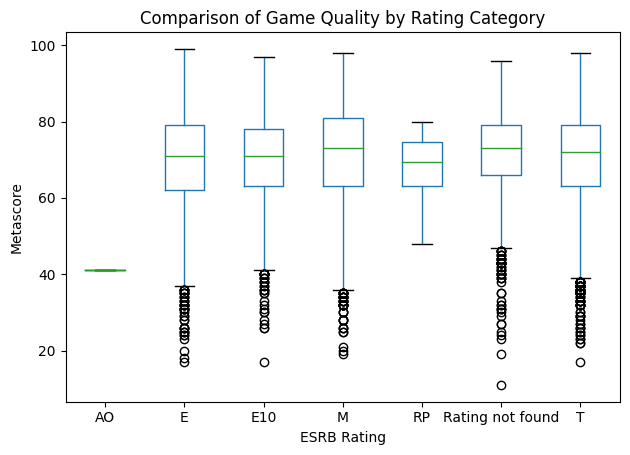

In [17]:
# Exclude games with invalid Metascores, such as those marked with -1 or "Metascore not available",
# to ensure the analysis is based on valid data points. This step filters the dataset to include only
# games with a positive Metascore value, indicating a legitimate score has been assigned.
valid_scores = games_by_year[games_by_year['metascore'] > 0]

# Initiate the creation of box plots to compare the distribution of Metascores across different ESRB ratings.
# Box plots are chosen for their ability to succinctly represent the distribution's quartiles and outliers,
# offering a clear visual comparison of game quality as rated by critics across rating categories.
plt.figure(figsize=(10, 6))  # Set the figure size to ensure the box plots are clearly visible and not cramped.

# Generate the box plots for Metascores, grouped by the ESRB rating of each game.
# The 'column' parameter specifies the data to be plotted, while 'by' determines the grouping variable.
valid_scores.boxplot(column='metascore', by='rating', grid=False)

# Title the plot and label the axes to clearly convey what the visualization represents:
# a comparison of game quality, as indicated by Metascores, across different ESRB rating categories.
plt.title('Comparison of Game Quality by Rating Category')
plt.suptitle('')  # Remove the automatically generated subplot title to avoid redundancy and clutter.

# Label the x-axis as "ESRB Rating" to indicate the grouping variable, and the y-axis as "Metascore" to denote
# the data being compared across the groups. This labeling helps in making the plot self-explanatory.
plt.xlabel('ESRB Rating')
plt.ylabel('Metascore')

# Apply a tight layout to adjust the spacing of plot elements automatically, ensuring that all components
# are neatly presented and that labels and titles do not overlap or go beyond the figure area.
plt.tight_layout()

# Display the box plot, showcasing the variability and central tendency of Metascores within each ESRB rating category.
# This visualization aids in understanding if and how game quality, as rated by critics, varies with content ratings.
plt.show()


### <a id='toc1_4_14_'></a>[Titles and descripitions word clouds](#toc0_)

The word clouds created from game titles and descriptions provide a visual representation of the most frequently occurring words within those texts.

In the word cloud generated from game titles, we see a dominance of words like "War," "Adventure," "Game," "World," "Final," "Fantasy," "Star," and "Dark." This suggests that themes of conflict, exploration, and fantasy are prevalent in the titles of games, possibly reflecting popular genres and narratives that appeal to a broad audience.

The word cloud from game descriptions shows a focus on gameplay elements with words like "Experience," "Play," "World," "Action," "Team," "Adventure," "Battle," and "Character." This indicates that descriptions often emphasize the interactive and immersive nature of games, highlighting aspects like teamwork, action, and character-driven stories.

The analysis of word clouds reveals prevalent themes and elements within the gaming industry. Titles tend to emphasize grand and immersive themes, which can be indicative of the genres that are popular or considered marketable. Descriptions, on the other hand, focus on the experiential features of games, suggesting that publishers prioritize conveying the dynamic and interactive aspects of games to potential consumers. These findings reflect the marketing strategies in the industry and can provide insights into what aspects are highlighted to capture the interest of gamers.

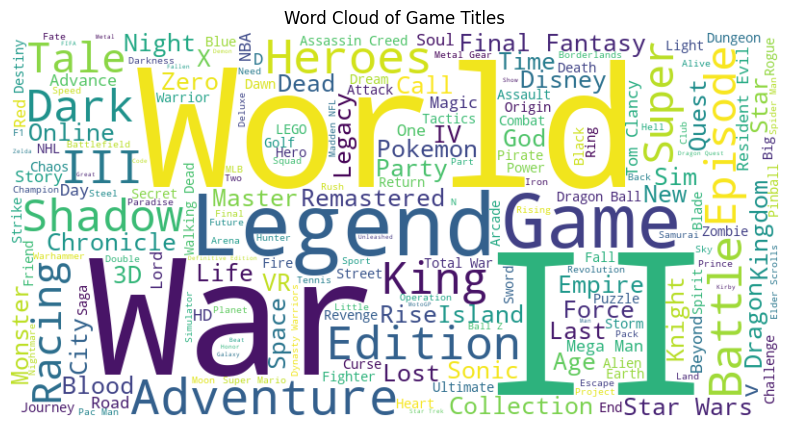

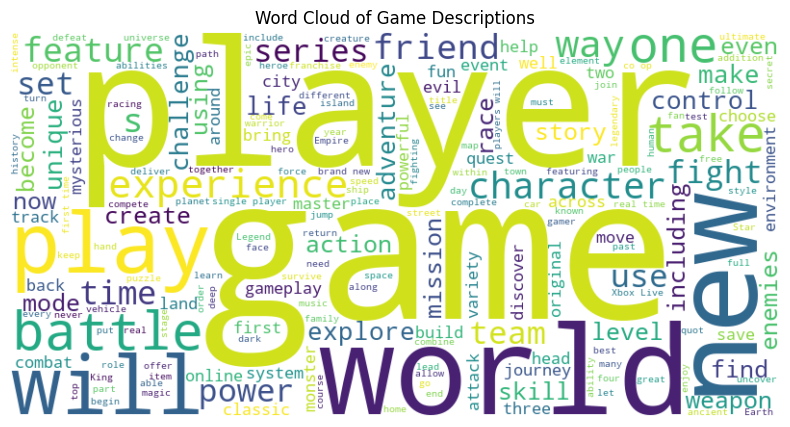

In [18]:
# Combine all game titles from the dataset into a single string.
# This aggregation is necessary for generating a word cloud that visualizes the most common words in game titles.
all_titles = ' '.join(games_by_year['title'].tolist())

# Similarly, combine all game descriptions into a single string to prepare for word cloud generation.
# This allows for the visualization of prevalent terms in the descriptions, providing insight into common themes or features.
all_descriptions = ' '.join(games_by_year['description'].tolist())

# Generate a word cloud from the aggregated game titles.
# The word cloud visualizes the frequency of word occurrence, with more common words appearing larger.
wordcloud_titles = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# Generate a word cloud for the combined game descriptions using similar settings.
# This word cloud will highlight the most frequent terms used in game descriptions, offering insights into common content or themes.
wordcloud_descriptions = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

# Display the word cloud for game titles.
# Set the figure size for optimal visibility and use bilinear interpolation for smoother display.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis('off')  # Hide the axis as they are not relevant for a word cloud visualization.
plt.title('Word Cloud of Game Titles')  # Title the plot to indicate the content source of the word cloud.
plt.show()

# Display the word cloud generated from game descriptions.
# Follow the same visualization settings as for the titles to maintain consistency.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_descriptions, interpolation='bilinear')
plt.axis('off')  # Axes are hidden because the focus is on the visual representation of text data.
plt.title('Word Cloud of Game Descriptions')  # Clearly label the plot to reflect its data source.
plt.show()

## <a id='toc1_5_'></a>[Insights and Interpretations](#toc0_)
The exploratory data analysis (EDA) of Metacritic game data has yielded several valuable insights into the gaming industry:

* __Game Releases Over Time__: There was an observable peak in the number of games released in the mid-2000s, followed by a stabilization and a recent decline. This could reflect market saturation and a subsequent focus on fewer, higher-quality titles.

* __Seasonality of Releases__: A significant increase in game releases during the last quarter suggests strategic timing for the holiday season, which is a key sales period for the industry.

* __High vs. Low Metascore Games__: The number of high Metascore games has seen a relative increase in recent years, indicating a possible shift toward quality in game development.

* __Multi-Platform Releases__ : Most games are released on a single platform, with a decreasing number released across multiple platforms. This could highlight the complexities and costs associated with multi-platform development.

* __Consistency Across Platforms__: The strong correlation between platform scores and Metascores suggests that game quality is maintained across different systems.

* __ESRB Rating Impact__: The ESRB rating does not significantly affect the critical reception of a game, with similar quality observed across content maturity levels.

* __Word Cloud Analysis__: The prevalence of words like "War," "Adventure," and "Action" in titles and descriptions indicates that these themes are commonly used in the gaming industry.

## <a id='toc1_6_'></a>[Conclusion](#toc0_)
The key findings from this EDA provide a comprehensive view of the gaming industry's evolution:

* The industry shows a trend of releasing more high-quality games, even if the total number of releases is declining. This could mean a future where gamers can expect fewer but more polished titles.

* The seasonality in game releases underscores the importance of strategic marketing and timing for game publishers.

* There is consistency in the quality of games across platforms, suggesting that the gaming experience is becoming more uniform for players, regardless of their platform of choice.

* ESRB ratings do not have a significant impact on game quality, indicating that content maturity levels are not necessarily a factor in the critical success of a game.

For gamers, these insights suggest a stable supply of quality games and the potential for a more consistent experience across platforms. Developers might consider focusing on high-quality titles and the strategic timing of releases. For the industry, the trend toward fewer, higher-quality games could necessitate changes in production and marketing strategies.

Areas for further research could include:

* Investigating the causes behind the decline in game releases. Is it due to market saturation, increased development costs, or a shift in consumer behavior?

* Analyzing the economic impact of the seasonality of game releases on the industry's financial health.

* Exploring the reasons behind the uniformity in game quality across platforms. How do development strategies and technological advancements contribute to this consistency?

* Examining the impact of ESRB ratings on sales and player demographics, beyond critical reception.

* Analyzing the games in similar way but with inclusion of genres

By delving into these areas, stakeholders can gain deeper insights into the gaming industry's future trajectory and make informed decisions to adapt to these trends.